In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, BooleanType, MapType, LongType
import math
import time

In [0]:
def is_prime(number):
        flag = True
        if number == 0 or number ==1:
            return False
        elif number == 2:
            return True
        else:
            index = 2
            while(index <= math.sqrt(number)):
                if(number%index==0):
                    return False
                index= index +1
            return True

is_prime_udf = udf(is_prime, BooleanType())

In [0]:
class PrimeDataFrame():
    def __init__(self): 
        return None

    def generate_dataframe(self,size,max_value, num_partitions=2):
        number_df = spark.range(0, size, 1,num_partitions).withColumn('value', round(rand(seed=42)*max_value,0).cast(LongType()))

        return number_df
    
    def filtered_prime_df(self, df):
        df_with_filtered_col = df.withColumn('is_prime', is_prime_udf(df.value))
        primeDF = df_with_filtered_col.filter(df_with_filtered_col.is_prime==True)
        return primeDF
    
    
    def count_value(self, df):
        start = time.time()
        count = df.count()
        end = time.time()
        count_time = end-start
        return count, count_time
    
    def sum_value(self,df):
        start = time.time()
        total = df.agg(sum("value")).collect()[0][-1]
        end = time.time()
        sum_time = end-start
        return total, sum_time
    

In [0]:
size = 100000
max_value = 1000
number_partition = 2

PrimeNumberGrenerator = PrimeDataFrame()

df = PrimeNumberGrenerator.generate_dataframe(size, max_value, number_partition)

prime_df = PrimeNumberGrenerator.filtered_prime_df(df)

prime_df.show()

+-----+-----+--------+
|   id|value|is_prime|
+-----+-----+--------+
|34229|  739|    true|
|14063|  547|    true|
| 7722|  109|    true|
| 3881|  401|    true|
| 4654|  449|    true|
|44320|  557|    true|
| 7736|  487|    true|
| 3424|  107|    true|
|44442|  443|    true|
| 5642|  439|    true|
|45931|  479|    true|
|47896|  151|    true|
|18152|  883|    true|
| 3474|  787|    true|
|43947|   61|    true|
| 7650|  587|    true|
|37089|   23|    true|
|21907|  461|    true|
| 5286|   97|    true|
|48590|  181|    true|
+-----+-----+--------+
only showing top 20 rows



In [0]:
count, count_time = PrimeNumberGrenerator.count_value(prime_df)
print("Number prime: ", count, "- Time: ", count_time)

Number prime:  16892 - Time:  1.5926926136016846


In [0]:
total, sum_time = PrimeNumberGrenerator.sum_value(prime_df)
print("Sum of prime: ", total, "- Time: ", sum_time)

Sum of prime:  7639561 - Time:  1.394909143447876


In [0]:
number_partition = [1,2,3,4,5,6]
time_sum = []
time_count = []

for i in number_partition:
    PrimeNumberGrenerator = PrimeDataFrame()
    df = PrimeNumberGrenerator.generate_dataframe(size, max_value, i)
    prime_df = PrimeNumberGrenerator.filtered_prime_df(df)

    count, count_time = PrimeNumberGrenerator.count_value(prime_df)
    total, sum_time = PrimeNumberGrenerator.sum_value(prime_df)

    time_sum.append(sum_time)
    time_count.append(count_time)

[0.9902770519256592, 1.2665207386016846, 1.0317580699920654, 1.4225285053253174, 0.9424629211425781, 1.0460071563720703] [0.9141724109649658, 1.0297207832336426, 1.0509798526763916, 0.9083333015441895, 0.9160699844360352, 0.9558217525482178]


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

statistic_df = pd.DataFrame({"number_partition":number_partition, "time_of_sum": time_sum, "time_of_count":time_count})

In [0]:
statistic_df

,number_partition,time_of_sum,time_of_count
0,1,0.990277,0.914172
1,2,1.266521,1.029721
2,3,1.031758,1.050980
3,4,1.422529,0.908333
4,5,0.942463,0.916070
5,6,1.046007,0.955822


In [0]:
statistic_df.corr()

,number_partition,time_of_sum,time_of_count
number_partition,1.000000,-0.086617,-0.233786
time_of_sum,-0.086617,1.000000,0.011246
time_of_count,-0.233786,0.011246,1.000000


Out[105]: <AxesSubplot:>

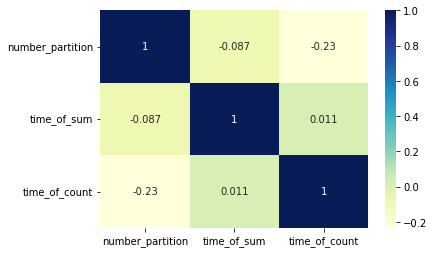

In [0]:
sns.heatmap(statistic_df.corr(),annot=True, cmap="YlGnBu")

Out[107]: <AxesSubplot:xlabel='time_of_sum', ylabel='number_partition'>

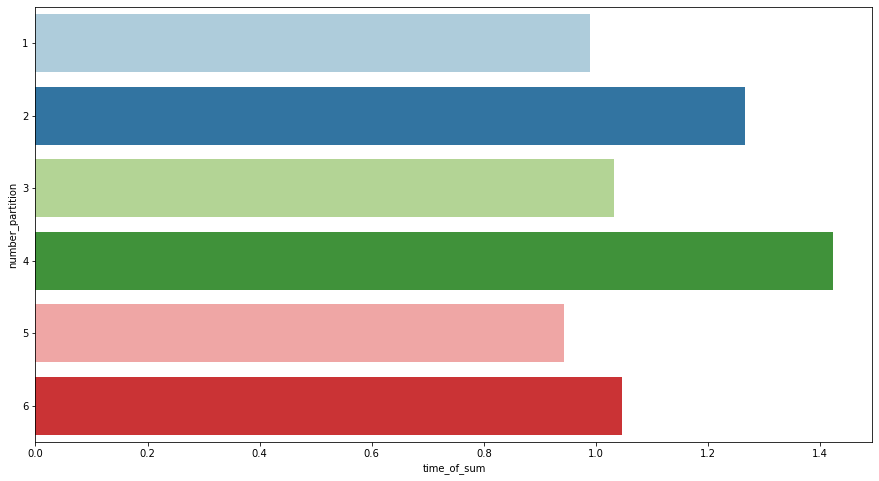

In [0]:
plt.figure(figsize=(15,8))
sns.barplot(data=statistic_df, y="number_partition", x="time_of_sum", orient='h', palette=sns.color_palette("Paired"))

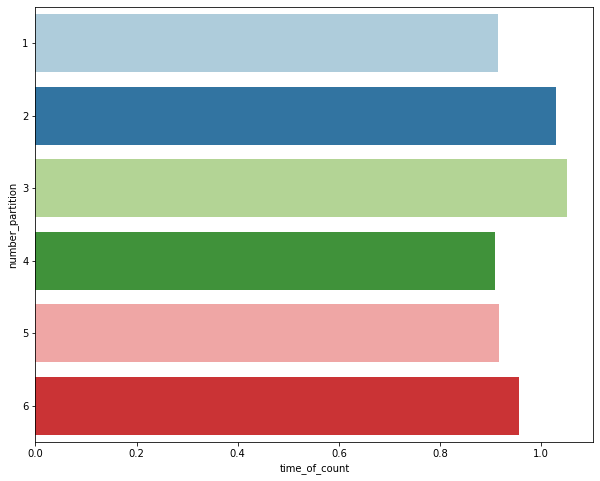

In [0]:
plt.figure(figsize=(10,8))
sns.barplot(data=statistic_df, y="number_partition", x="time_of_count", orient='h', palette=sns.color_palette("Paired"))
plt.show()